In [3]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


In [4]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)


# Visualize the training (and test) dataset

### Zero final velocity dataset with only first iterations of GuSTO stored

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training data
Random i = 340


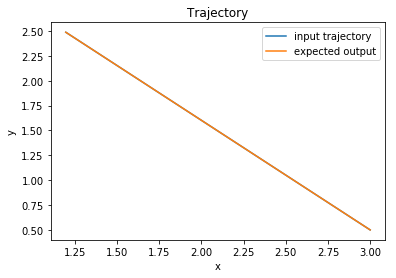

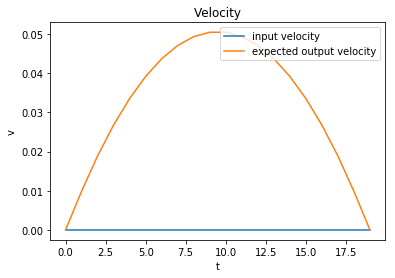

Random i = 106


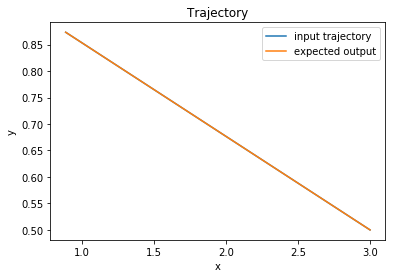

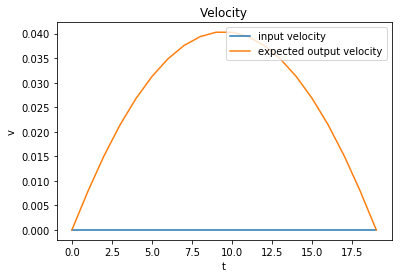

Random i = 295


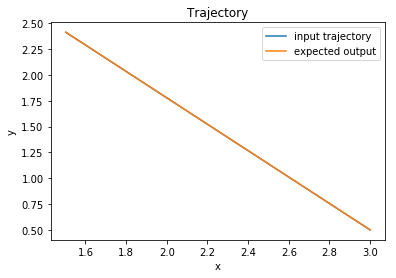

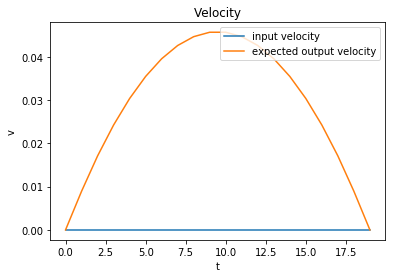

Random i = 260


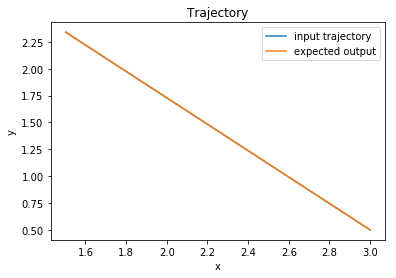

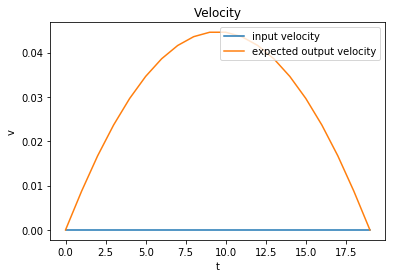

Random i = 447


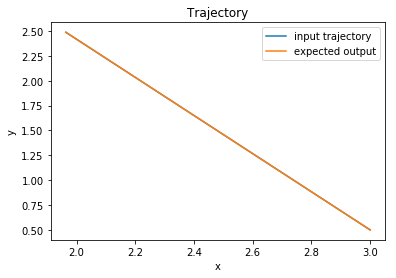

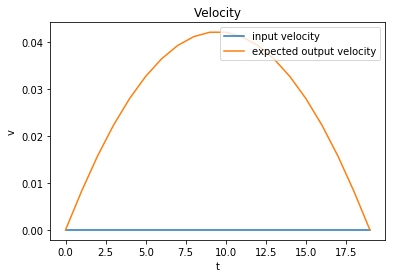

Random i = 24


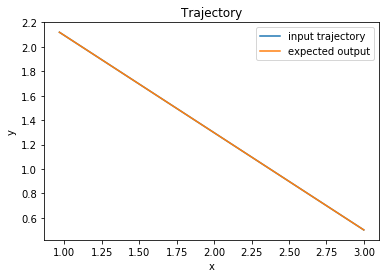

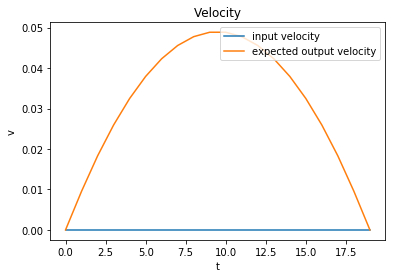

Random i = 292


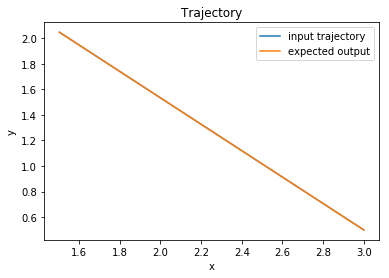

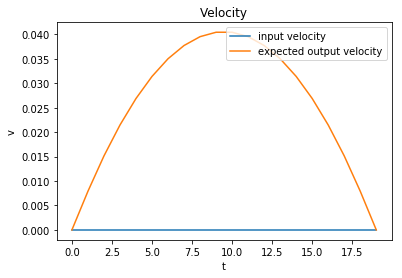

Random i = 365


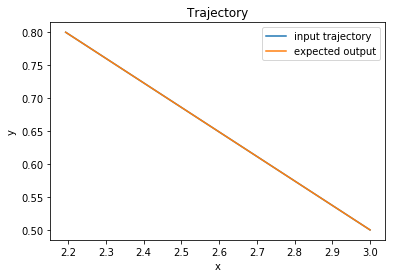

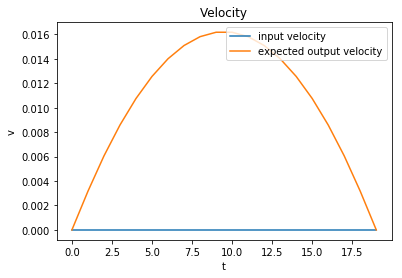

Test data
Random i = 119


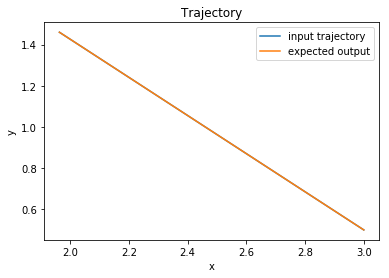

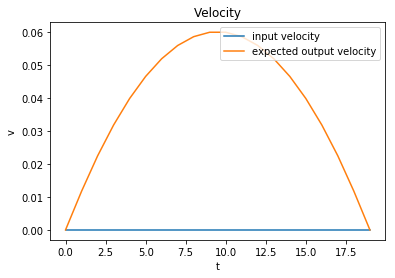

Random i = 32


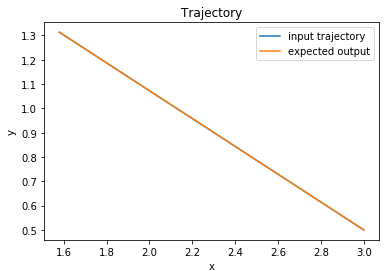

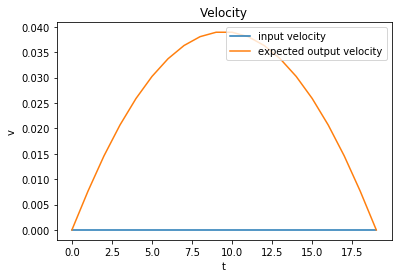

Random i = 130


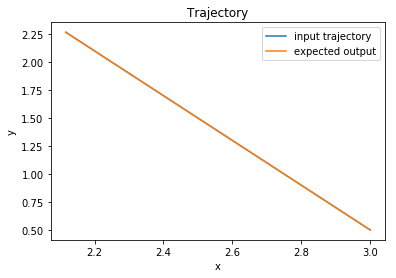

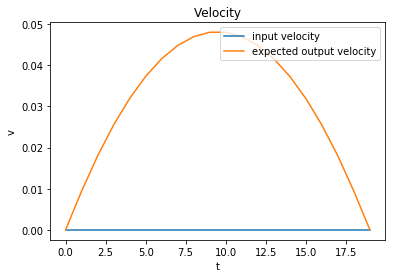

Random i = 156


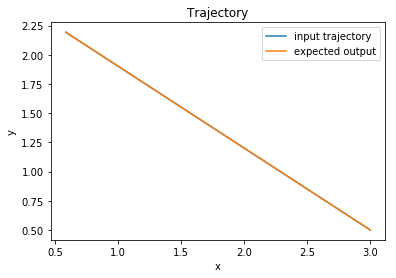

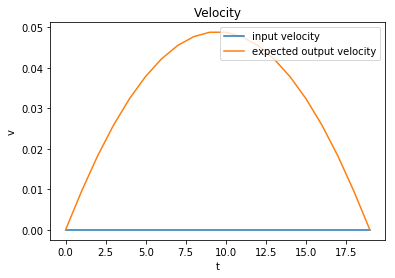

Random i = 10


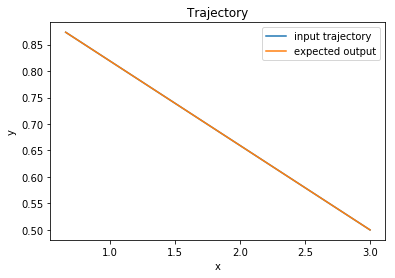

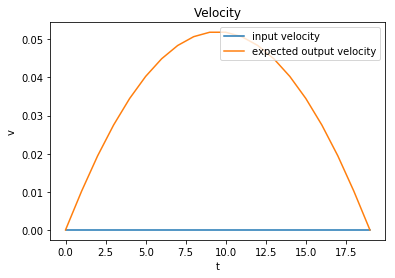

Random i = 52


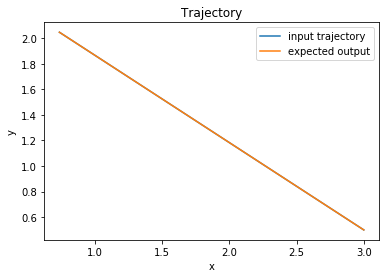

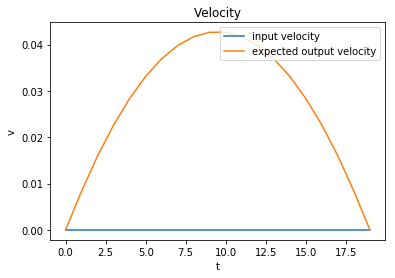

Random i = 139


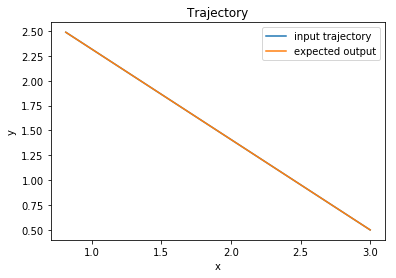

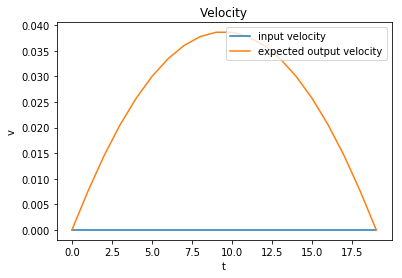

Random i = 12


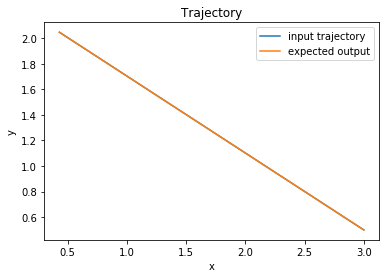

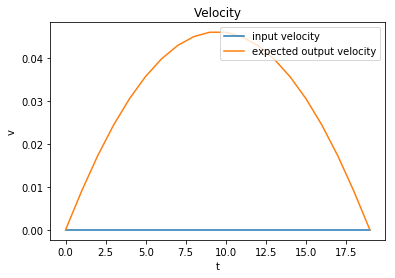

In [13]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

print("Training data")
for x in range(8):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(8):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])



## Note that the xy trajectory always remains a straight line and the velocity changes from a constant zero to a parabolic curve

# Try to overfit data! Bigger network and dataset with zero final velocity

In [123]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

X_max = np.amax

# Overfit to exactly 2 samples!
# numSamples = 30
# X_train = X_train[0:numSamples,:]
# X_test = X_test[1:4,:]
# Y_train = Y_train[0:numSamples,:]
# Y_test = Y_test[1:4,:]

X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

xMin = np.amin(X, axis=0)
xMax = np.amax(X, axis=0)
xRange = xMax - xMin
xRange[xRange == 0] = 1.0

X_train = (X_train-xMin)/xRange
X_test = (X_test-xMin)/xRange

# print(np.amin(X_train, axis=0))
# print(np.shape(X_train))
# print(np.shape(Y_train))

yMin = np.amin(Y_train, axis=0)
yMax = np.amax(Y_train, axis=0)
# print(np.shape(yMin))
# print(np.shape(yMax))
# print(yMin[1:10])
# print(yMax[1:10])

yRange = yMax - yMin
# print(yRange[1:10])
yRange[yRange == 0] = 1.0
# print(yRange[1:10])
Y_train = (Y_train-yMin)/yRange
Y_test = (Y_test-yMin)/yRange

# print(np.amax(Y_train, axis=0))

# print(np.shape(X_train))
# print(np.shape(Y_train))

# print(Y_train[:,1:10])
# Creating my own data
# X_train = np.random.rand(1,182)
# X_train = np.random.uniform(-1,1,(1,182))

# Y_train = np.zeros((1,180))

# What's weird is that if you make X_train a (1,182) vector of random numbers betweeen (-1,1) 
# and Y_train the original vector, the loss stops at 0.0010 or 0.0012 and won't go down

# Switch to tanh activation and the loss stops going down at 0.0214

# tanh just seems horrible. Even with y_train as all zeros, the loss stops at 0.0060 
# whereas for relu with y_train as all zeros, we get 1e-6 range loss

# using last layer as linear with y_train as initial makes the loss stop at 2.68e-4
# adding another layer at end as linear makes loss go to 1e-4

# I can use 1 sample of X_train with 2 ending linear layers and  make the loss stop at 2.81e-4

# All linear makes it go to 0.0016

# alternating relu and linear is 2.56e-4

# double size (layers) network is 2.0248e-4

# Now I normalized the Y_train values to be between 0 and 1. Kept the double size relu linear layers 
# and tried 30 samples. Loss stops at 0.0635

# Changed network so all layers are relu. Again tried 30 samples. Loss stops at 0.0901

# Added a few layers. Loss stops going down at 0.0886

# Put in all the samples. Loss stop at 0.0468

# Also normalized x now. Loss drops to 0.03 after a few epochs.

# create the model
model = Sequential()
# model.add(Dense(512, input_dim=182, activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(512, kernel_initializer='uniform', activation='tanh'))
# model.add(Dense(180, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, input_dim=182, activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(512, kernel_initializer='uniform', activation='linear'))
# model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [14]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
# Overfit to exactly 2 samples!
numSamples = 2
X_train = X_train[1:numSamples,:]
# X_test = X_test[1:4,:]
Y_train = Y_train[1:numSamples,:]
# Y_test = Y_test[1:4,:]

# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=1e-50)

lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 484 samples, validate on 162 samples
Epoch 1/30
484/484 [==============================] - 38s 78ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - val_loss: 0.0696 - val_mean_squared_error: 0.0696
Learning rate:  0.001
Epoch 2/30
484/484 [==============================] - 31s 64ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Learning rate:  0.001
Epoch 3/30
484/484 [==============================] - 31s 65ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Learning rate:  0.001
Epoch 4/30
484/484 [==============================] - 35s 72ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Learning rate:  0.001
Epoch 5/30
484/484 [==============================] - 43s 88ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Learning rate:  0.001
Epoch 6/30
484/484 [====

In [ ]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

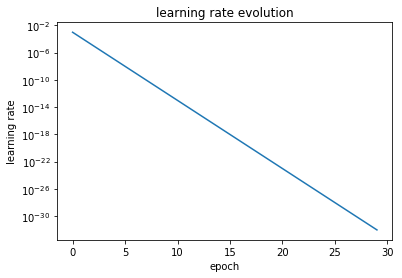

In [27]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [18]:
# save model to hdf5 file
# model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5') 

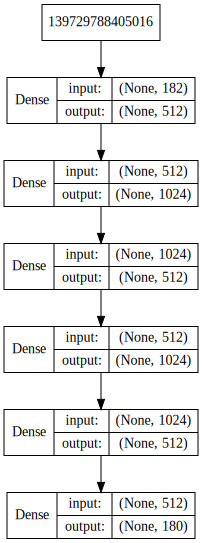

In [19]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Run model on some inputs and plot results

## Newer model, bigger network, first iteration only

### Try training data

In [110]:
# model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

Idx = [0,1,2]
X_train_np_array=np.array(X_train)
NN_output = model.predict(X_train_np_array[Idx])
NN_output = NN_output*yRange + yMin

Training Examples


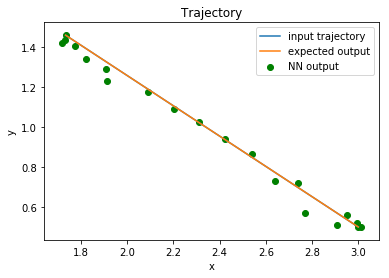

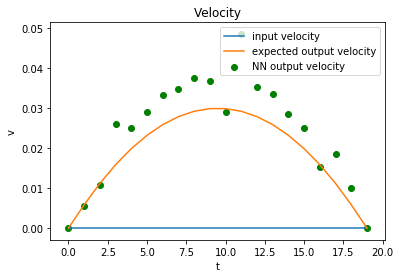

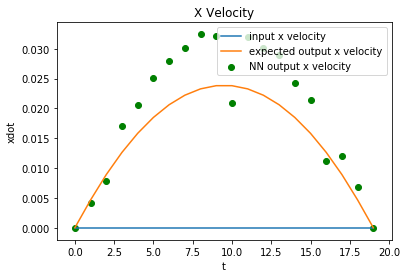

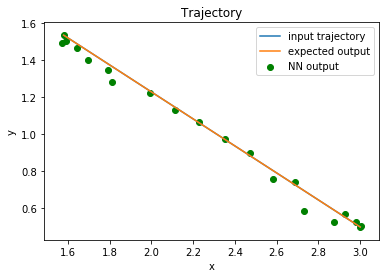

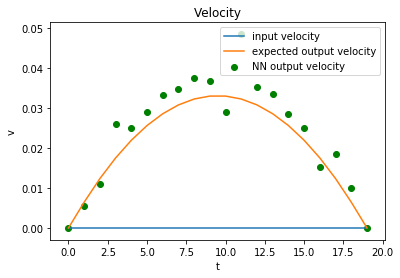

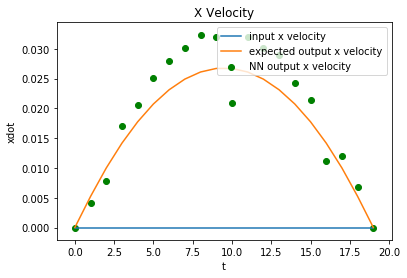

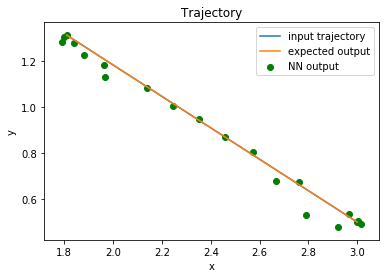

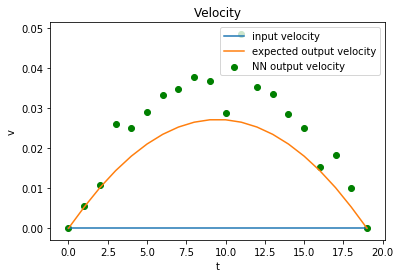

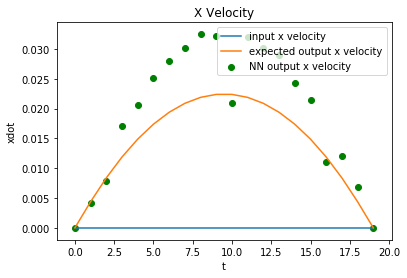

In [111]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotXVelocityInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])



### Try test data

In [112]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])
NN_output = NN_output*yRange + yMin

(4, 180)
Test Examples


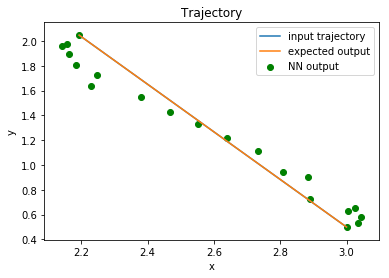

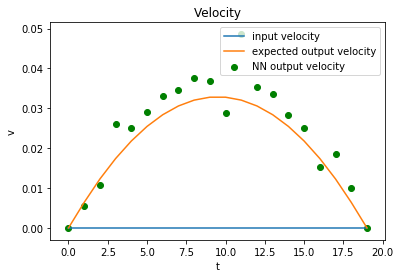

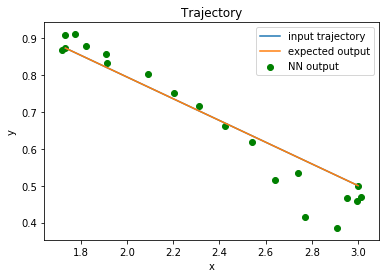

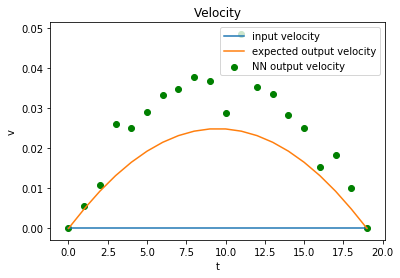

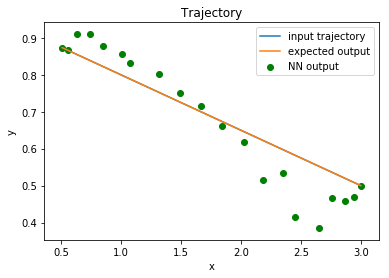

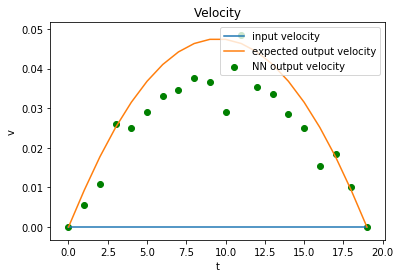

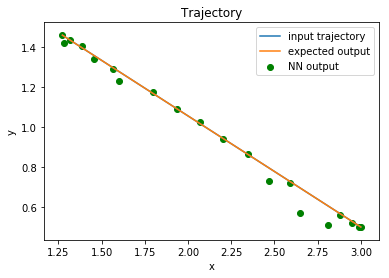

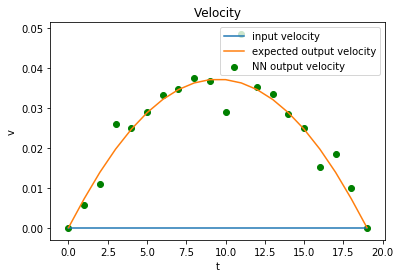

In [113]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


# Helper functions below

## Load data and create test and training inputs and outputs

In [6]:
# filenames must be a list
def loadData(filenames, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    
    # split the data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, Y_train, Y_test



## Create custom metric to print learning rate after each epoch

In [7]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)

## Function to plot trajectory from row of training data

In [8]:
def plotTrajectoryFromInput(X_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    x = X_data[0:120:6] 
    y = X_data[1:120:6]
#     print(np.shape(x))
#     print(np.shape(y))
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
def plotTrajectoryInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xOut = xIn + Y_data[0:120:6]
    yOut = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(xIn, yIn)
    plt.plot(xOut, yOut)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output'], loc='upper right')
    plt.show()

In [10]:
def plotVelocitiesInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotOut = np.array(xDotIn + Y_data[3:120:6])
    yDotOut = np.array(yDotIn + Y_data[4:120:6])
    velOut = np.sqrt(xDotOut**2 + yDotOut**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(velIn)
    plt.plot(velOut)
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity'], loc='upper right')
    plt.show()

In [11]:
def plotTrajectoryInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xExp = xIn + Y_data[0:120:6]
    yExp = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))

    xNN = xIn + NN_data[0:120:6]
    yNN = yIn + NN_data[1:120:6]
    
    plt.plot(xIn, yIn)
    plt.plot(xExp, yExp)
    plt.scatter(xNN, yNN,color='g')
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output', 'NN output'], loc='upper right')
    plt.show()

In [12]:
def plotVelocitiesInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
    yDotExp = np.array(yDotIn + Y_data[4:120:6])
    velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
    yDotNN = np.array(yDotIn + NN_data[4:120:6])
    velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(velIn)
    plt.plot(velExp)
    plt.scatter(np.arange(np.size(velNN,0)), velNN,color='g')
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity', 'NN output velocity'], loc='upper right')
    plt.show()

In [79]:
def plotXVelocityInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
#     yDotIn = np.array(X_data[4:120:6])
#     velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
#     yDotExp = np.array(yDotIn + Y_data[4:120:6])
#     velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
#     yDotNN = np.array(yDotIn + NN_data[4:120:6])
#     velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(xDotIn)
    plt.plot(xDotExp)
    plt.scatter(np.arange(np.size(xDotNN,0)), xDotNN,color='g')
    plt.title('X Velocity')
    plt.ylabel('xdot')
    plt.xlabel('t')
    plt.legend(['input x velocity', 'expected output x velocity', 'NN output x velocity'], loc='upper right')
    plt.show()